In [3]:
import numpy as np 
import pandas as pd
import matplotlib 
import matplotlib.pyplot as plt

def set_mpl_params():
    matplotlib.rcdefaults()
    matplotlib.rcParams['text.usetex'] = True            # Use LaTeX for text rendering

    # Update font settings
    matplotlib.rcParams.update({
        'font.family': 'serif',                          # Use serif font family
        'font.serif': 'Palatino',                        # Use Palatino as the standard font
        'text.latex.preamble': r'\usepackage{amsmath} \usepackage{mathpazo}',  # Use the amsmath and mathpazo package for LaTeX
    })

    # Customize the figure size
    matplotlib.rcParams['figure.figsize'] = (8, 6)   # Set the default figure size

    # Customize axes
    matplotlib.rcParams['axes.labelsize'] = 24       # Axis label font size
    matplotlib.rcParams['axes.titlesize'] = 24       # Axis title font size
    matplotlib.rcParams['axes.titlepad'] = 15        # Axis title padding
    matplotlib.rcParams['axes.linewidth'] = 1.5        # Axis line width

    # Customize ticks
    matplotlib.rcParams['xtick.labelsize'] = 20      # X-axis tick label size
    matplotlib.rcParams['ytick.labelsize'] = 20      # Y-axis tick label size
    matplotlib.rcParams['xtick.major.width'] = 1.2   # X-axis major tick width
    matplotlib.rcParams['ytick.major.width'] = 1.2   # Y-axis major tick width
    matplotlib.rcParams['xtick.minor.size'] = 4      # X-axis minor tick size
    matplotlib.rcParams['ytick.minor.size'] = 4      # Y-axis minor tick size
    matplotlib.rcParams['xtick.major.size'] = 8      # X-axis major tick size
    matplotlib.rcParams['ytick.major.size'] = 8      # Y-axis major tick size

    # Customize legend
    matplotlib.rcParams['legend.fontsize'] = 20      # Legend font size
    matplotlib.rcParams['legend.frameon'] = True     # Enable/Disable the frame around the legend

    # Customize grid
    matplotlib.rcParams['grid.color'] = 'gray'       # Grid color
    matplotlib.rcParams['grid.linestyle'] = '-'      # Grid line style
    matplotlib.rcParams['grid.linewidth'] = 0.5      # Grid line width

    # Customize lines
    matplotlib.rcParams['lines.linewidth'] = 2.5       # Line width
    matplotlib.rcParams['lines.markersize'] = 10       # Marker size

    # Change figure and axes background colors
    matplotlib.rcParams['figure.facecolor'] = 'white'    # Figure background color
    matplotlib.rcParams['axes.facecolor'] = 'white'      # Axes background color
    
set_mpl_params()

In [4]:
def create_vacancy(filename):
    with open(filename, "r") as file:
        lines = file.readlines()

    # Find and update the number of atoms (first line)
    first_line_parts = lines[2].split()
    num_atoms = int(first_line_parts[0])  # Extract the number of atoms
    first_line_parts[0] = str(num_atoms - 1)  # Update it to n - 1
    lines[2] = " ".join(first_line_parts) + "\n"  # Reconstruct the line

    # Remove the last atom line
    modified_lines = lines[:-1]

    # Create a new filename for the modified file
    new_filename = filename[:-4] + "_vacancy.lmp"

    with open(new_filename, "w") as file:
        file.writelines(modified_lines)


for i in range(1, 15): 
    filename = f"LJ/Ag_Supercell_{i}x{i}x{i}.lmp"
    create_vacancy(filename)

In [5]:
def plot_E_vacancy(df, col1="N", col2="Vacancy Formation Energy", 
                   ax=None, title=None, marker='o',  markeredgecolor='black', color='skyblue',
                   markersize=10, markeredgewidth=1.5):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.plot(df[col1], df[col2], marker=marker, markerfacecolor="None", markeredgecolor=markeredgecolor, linestyle="--", 
            linewidth=1.5, color=color, markersize=markersize,  markeredgewidth= markeredgewidth)
    ax.axhline(df[col2].iloc[-1], color="black", linestyle=":", label=rf"$E_{{\rm f,v}} = {df[col2].iloc[-1]:.5f}$ eV")
    ax.set_xlabel(r"Number of atoms")
    ax.set_ylabel(r"$E_{\rm f,v}$ [eV]")
    ax.set_xscale("log")
    ax.legend()
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", alpha=0.5)

    if ax.get_subplotspec().is_last_col():
        ax.set_ylabel("")
    
    return ax

In [6]:
def compute_vacation_formation_energy(filename_no_vacancy, filename_vacancy): 
    df_vacancy = pd.read_csv(filename_vacancy, header=None, names=["E_vacancy"])
    df_no_vacancy = pd.read_csv(filename_no_vacancy, header=None, names=["E_no_vacancy"])
    df = pd.concat([df_vacancy, df_no_vacancy], axis=1)
    df["N"] = pd.Series([4, 32, 108, 256, 500, 864, 1372, 2048, 2916, 4000, 5324, 6912, 8788, 10976])
    df["N-1"] = df["N"] - 1
    df["Bulk Energy"] = df["E_no_vacancy"] / df["N"]
    df["Vacancy Formation Energy"] = df["E_vacancy"] - (df["N-1"] / df["N"]) * df["E_no_vacancy"]
    df["|E_vac/E_coh|"] = np.abs(df["Vacancy Formation Energy"] / df["Bulk Energy"])

    # Compute convergence as the difference between the last two values 
    df["Convergence"] = df["Vacancy Formation Energy"].diff().abs()
    df["Converged"] = df["Convergence"] < 1e-5
    
    return df

## LJ interactions

In [7]:
df_no_relax = compute_vacation_formation_energy("LJ/energy_no_vacancy_no_relax.dat", "LJ/energy_with_vacancy_no_relax.dat")
df_relax = compute_vacation_formation_energy("LJ/energy_no_vacancy_with_relax.dat", "LJ/energy_with_vacancy_with_relax.dat")

display(df_no_relax)
display(df_relax)

print(f"Last energy no relax = {df_no_relax['Vacancy Formation Energy'].iloc[-1]}")
print(f"Last energy relax = {df_relax['Vacancy Formation Energy'].iloc[-1]}")

,E_vacancy,E_no_vacancy,N,N-1,Bulk Energy,Vacancy Formation Energy,|E_vac/E_coh|,Convergence,Converged
0,-6.149985,-11.514158,4,3,-2.878539,2.485633,0.863505,NaN,False
1,-86.360942,-92.113262,32,31,-2.878539,2.873780,0.998347,3.881475e-01,False
2,-305.125180,-310.882259,108,107,-2.878539,2.878539,1.000000,4.759042e-03,False
3,-731.149016,-736.906095,256,255,-2.878539,2.878539,1.000000,1.080025e-12,True
4,-1433.512638,-1439.269717,500,499,-2.878539,2.878539,1.000000,3.183231e-12,True
5,-2481.300992,-2487.058071,864,863,-2.878539,2.878539,1.000000,1.136868e-12,True
6,-3943.599024,-3949.356103,1372,1371,-2.878539,2.878539,1.000000,8.185452e-12,True
7,-5889.491681,-5895.248760,2048,2047,-2.878539,2.878539,1.000000,1.682565e-11,True
8,-8388.063909,-8393.820988,2916,2915,-2.878539,2.878539,1.000000,7.639755e-11,True
9,-11508.400655,-11514.157734,4000,3999,-2.878539,2.878539,1.000000,4.183676e-11,True


,E_vacancy,E_no_vacancy,N,N-1,Bulk Energy,Vacancy Formation Energy,|E_vac/E_coh|,Convergence,Converged
0,-6.152534,-11.514328,4,3,-2.878582,2.483212,0.862651,NaN,False
1,-86.362225,-92.114623,32,31,-2.878582,2.873816,0.998344,3.906047e-01,False
2,-305.129689,-310.886852,108,107,-2.878582,2.878581,1.000000,4.764397e-03,False
3,-731.159817,-736.916982,256,255,-2.878582,2.878583,1.000000,2.119040e-06,True
4,-1433.533815,-1439.290980,500,499,-2.878582,2.878583,1.000000,2.425423e-07,True
5,-2481.337650,-2487.094814,864,863,-2.878582,2.878583,1.000000,4.847793e-07,True
6,-3943.657287,-3949.414450,1372,1371,-2.878582,2.878581,1.000000,1.100620e-06,True
7,-5889.578694,-5895.335861,2048,2047,-2.878582,2.878585,1.000001,3.722078e-06,True
8,-8388.187838,-8393.945005,2916,2915,-2.878582,2.878585,1.000001,1.785338e-07,True
9,-11508.570686,-11514.327853,4000,3999,-2.878582,2.878585,1.000001,5.314359e-08,True


Last energy no relax = 2.878539433608239
Last energy relax = 2.8785833728725265


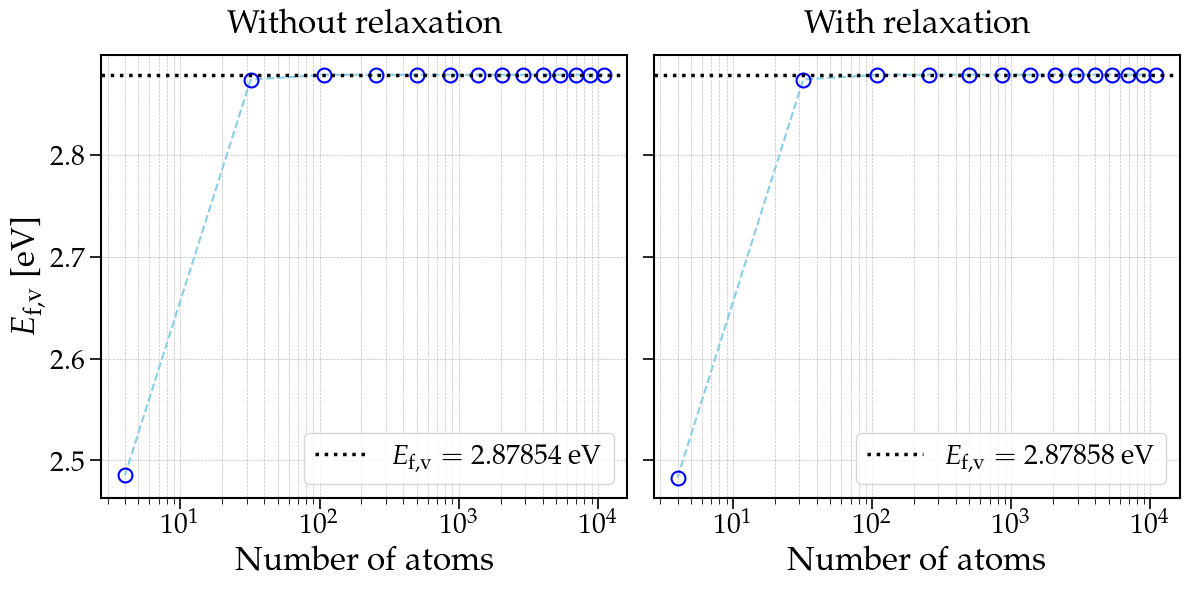

In [8]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)

# Plot on each subplot
plot_E_vacancy(df_no_relax, ax=axes[0], title="Without relaxation", markeredgecolor='blue')
plot_E_vacancy(df_relax, ax=axes[1], title="With relaxation", markeredgecolor='blue')
plt.tight_layout()
plt.show()


## EAM Model

In [9]:
df_eam_no_relax = compute_vacation_formation_energy("EAM/energy_no_vacancy_no_relax.dat", "EAM/energy_with_vacancy_no_relax.dat")
df_eam_relax = compute_vacation_formation_energy("EAM/energy_no_vacancy_with_relax.dat", "EAM/energy_with_vacancy_with_relax.dat")

display(df_eam_no_relax)
display(df_eam_relax)

print(f"Last energy no relax = {df_eam_no_relax['Vacancy Formation Energy'].iloc[-1]}")
print(f"Last energy relax = {df_eam_relax['Vacancy Formation Energy'].iloc[-1]}")

,E_vacancy,E_no_vacancy,N,N-1,Bulk Energy,Vacancy Formation Energy,|E_vac/E_coh|,Convergence,Converged
0,-7.524279,-11.399231,4,3,-2.849808,1.025145,0.359724,NaN,False
1,-87.379322,-91.193852,32,31,-2.849808,0.964722,0.338522,6.042314e-02,False
2,-303.964747,-307.779250,108,107,-2.849808,0.964695,0.338512,2.667648e-05,False
3,-725.736312,-729.550815,256,255,-2.849808,0.964695,0.338512,2.330580e-12,True
4,-1421.089433,-1424.903936,500,499,-2.849808,0.964695,0.338512,1.284661e-11,True
5,-2458.419498,-2462.234001,864,863,-2.849808,0.964695,0.338512,1.114131e-11,True
6,-3906.121896,-3909.936399,1372,1371,-2.849808,0.964695,0.338512,1.364242e-12,True
7,-5832.592017,-5836.406520,2048,2047,-2.849808,0.964695,0.338512,2.273737e-11,True
8,-8306.225249,-8310.039752,2916,2915,-2.849808,0.964695,0.338512,1.182343e-11,True
9,-11395.416982,-11399.231485,4000,3999,-2.849808,0.964695,0.338512,1.818989e-12,True


,E_vacancy,E_no_vacancy,N,N-1,Bulk Energy,Vacancy Formation Energy,|E_vac/E_coh|,Convergence,Converged
0,-7.580086,-11.400000,4,3,-2.85,0.969914,0.340321,NaN,False
1,-87.385676,-91.200000,32,31,-2.85,0.964324,0.338359,0.005590,False
2,-303.984789,-307.800000,108,107,-2.85,0.965212,0.338671,0.000888,False
3,-725.784475,-729.600000,256,255,-2.85,0.965525,0.338781,0.000313,False
4,-1421.183811,-1425.000001,500,499,-2.85,0.966190,0.339014,0.000665,False
5,-2458.583571,-2462.400001,864,863,-2.85,0.966431,0.339099,0.000241,False
6,-3906.384151,-3910.200002,1372,1371,-2.85,0.965851,0.338895,0.000580,False
7,-5832.983523,-5836.800003,2048,2047,-2.85,0.966480,0.339116,0.000629,False
8,-8306.783403,-8310.600005,2916,2915,-2.85,0.966601,0.339158,0.000121,False
9,-11396.182358,-11400.000006,4000,3999,-2.85,0.967648,0.339526,0.001047,False


Last energy no relax = 0.964695154230867
Last energy relax = 0.9676982716955536


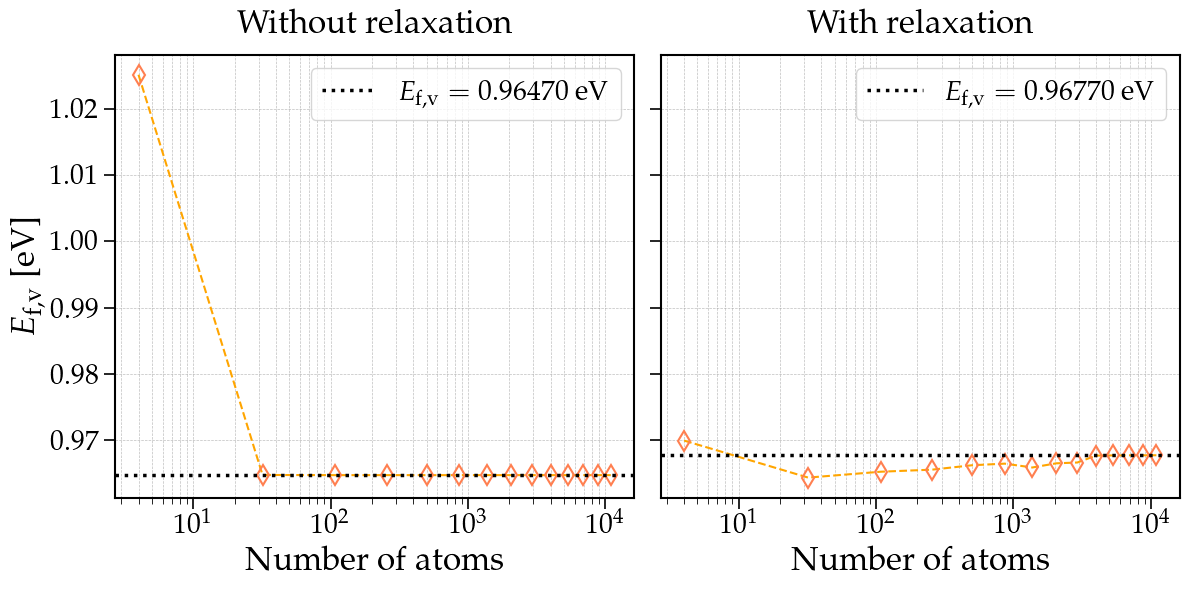

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=True)
plot_E_vacancy(df_eam_no_relax, ax=axes[0], title="Without relaxation", marker='d', markeredgecolor='coral', color="orange")
plot_E_vacancy(df_eam_relax, ax=axes[1], title="With relaxation", marker='d', markeredgecolor='coral', color="orange")
plt.tight_layout()
plt.show()

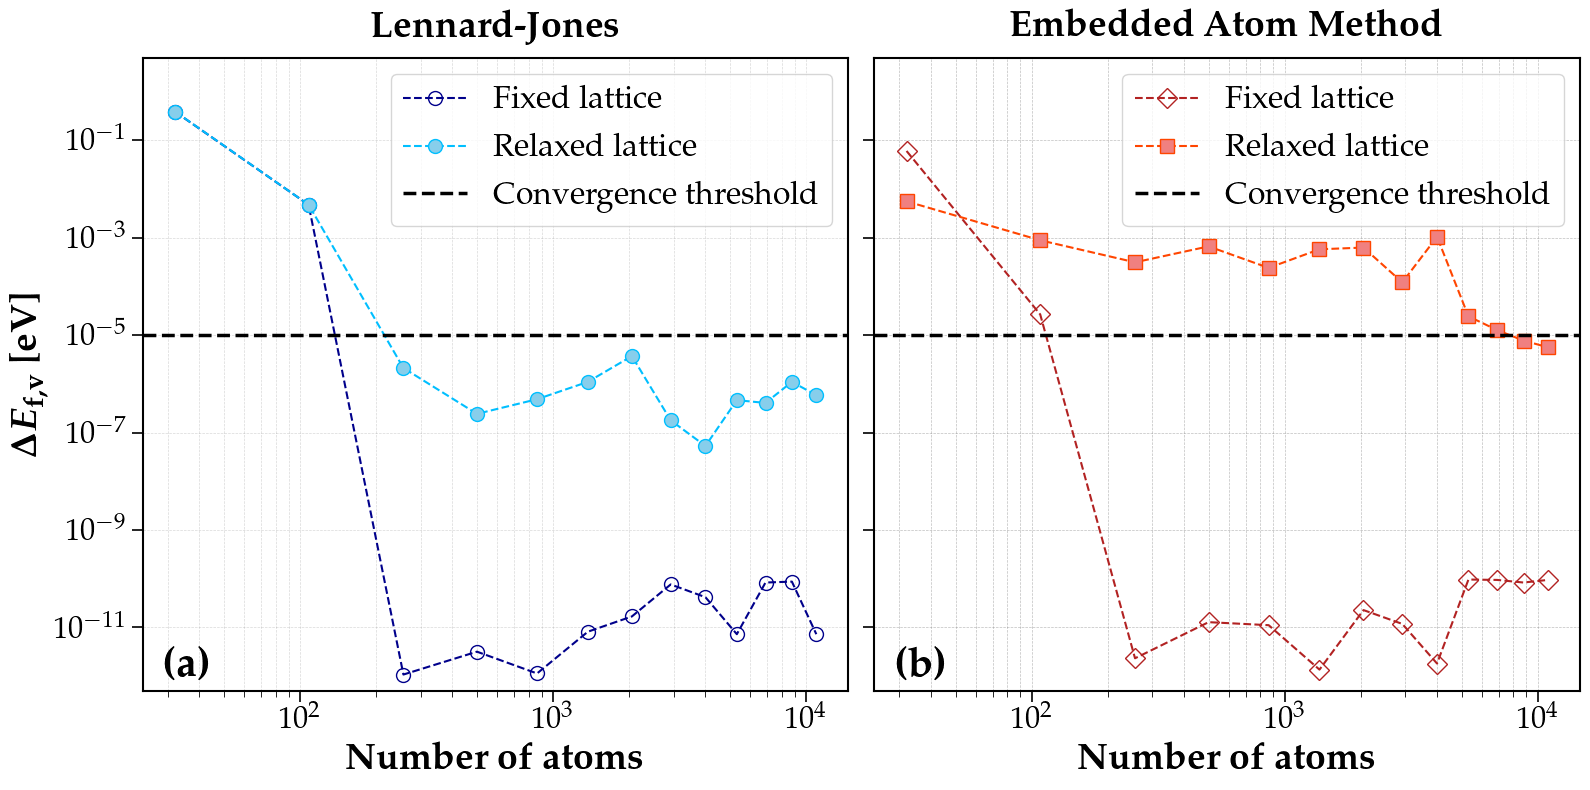

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey=True)

# Left plot (LJ)
ax[0].plot(df_no_relax["N"], df_no_relax["Convergence"], 
           marker="o", markerfacecolor="None", linestyle="--", 
           label="Fixed lattice", color="darkblue", markeredgecolor="darkblue", 
           linewidth=1.5, markersize=10)

ax[0].plot(df_relax["N"], df_relax["Convergence"], 
           marker="o", markerfacecolor="skyblue", linestyle="--", 
           label="Relaxed lattice", color="deepskyblue", markeredgecolor="deepskyblue", 
           linewidth=1.5, markersize=10)

ax[0].axhline(1e-5, color="black", linestyle="--", label=r"Convergence threshold")

ax[0].text(0.03, 0.07, r"\textbf{(a)}", transform=ax[0].transAxes, fontsize=30,
           verticalalignment='top', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_xlabel(r"\textbf{Number of atoms}", fontsize=27)
ax[0].set_ylabel(r"$\boldsymbol{\Delta E_{\rm f,v}}$  \textbf{[eV]}", fontsize=27)
ax[0].set_title(r"\textbf{Lennard-Jones}", fontsize=27)
ax[0].legend(fontsize=23)
ax[0].grid(True, which="both", linestyle="--", alpha=0.3)

# Right plot (EAM)
ax[1].plot(df_eam_no_relax["N"], df_eam_no_relax["Convergence"], 
           marker="D", markerfacecolor="None", linestyle="--", 
           label="Fixed lattice", color="firebrick", markeredgecolor="firebrick", 
           linewidth=1.5, markersize=10)

ax[1].plot(df_eam_relax["N"], df_eam_relax["Convergence"], 
           marker="s", markerfacecolor="lightcoral", linestyle="--", 
           label="Relaxed lattice", color="orangered", markeredgecolor="orangered", 
           linewidth=1.5, markersize=10)


ax[1].axhline(1e-5, color="black", linestyle="--", label=r"Convergence threshold")


ax[1].text(0.03, 0.07, r"\textbf{(b)}", transform=ax[1].transAxes, fontsize=30,
           verticalalignment='top', bbox=dict(facecolor='white', alpha=0, edgecolor='none'))

ax[1].set_xscale("log")
ax[1].set_yscale("log")
ax[1].set_xlabel(r"\textbf{Number of atoms}", fontsize=27)
ax[1].set_title(r"\textbf{Embedded Atom Method}", fontsize=27)
ax[1].legend(fontsize=23)
ax[1].grid(True, which="both", linestyle="--", alpha=0.5)

ax[0].tick_params(axis='both', which='major', labelsize=22)
ax[1].tick_params(axis='both', which='major', labelsize=22)
ax[0].set_ylim(5e-13, 5)

plt.tight_layout()
plt.savefig("Figures/convergence.pdf", bbox_inches="tight")
plt.show()
